In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from textblob import TextBlob
# 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import ast
import itertools
from wordcloud import WordCloud, STOPWORDS

# READING THE DATA FROM FILE IN DATA FRAMES

In [4]:
#FILE BEING DOWNLOADED FROM KAGGLE 
df_raw = pd.read_csv('Bitcoin_tweets.csv',low_memory=False)
print(df_raw.shape)
df_raw.head()

(2259788, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


# DATA CLEANING

In [6]:
# REMOVING NAN VALUES
df_raw.dropna(axis=0 ,subset=['date','text'],inplace = True)
df_raw.reset_index(drop= True,inplace=True)
df_raw.shape

(2259650, 13)

In [ ]:
# REMOVING DUPLICACY IF THERE IS ANY
df_raw.drop_duplicates(inplace = True)
df_raw.reset_index(drop=True,inplace=True)
df_raw.shape

(2259650, 13)

In [ ]:
df_raw.dtypes

user_name            object
user_location        object
user_description     object
user_created         object
user_followers      float64
user_friends         object
user_favourites      object
user_verified        object
date                 object
text                 object
hashtags             object
source               object
is_retweet           object
dtype: object

In [ ]:
# CONVERTING DATA TYPE IN CONSISTENT TYPE FOR WHOLE DATASET
df_raw = df_raw.convert_dtypes()
df_raw.dtypes

user_name            string
user_location        string
user_description     string
user_created         string
user_followers        Int64
user_friends         string
user_favourites      string
user_verified        string
date                 string
text                 string
hashtags             string
source               string
is_retweet          boolean
dtype: object

In [ ]:
#CLEANING THE DATE FILED WHICH HAS INVALID VALUE
errors = []
for i,v in enumerate(df_raw['date']):
    try:
        pd.to_datetime(v, format='%Y-%m-%d %H:%M:%S')
    except ValueError:
        errors.append(i)
df_clean = df_raw.loc[~df.index.isin(errors)]
df_clean.reset_index(drop=True,inplace=True)
df_clean.shape

(2259638, 13)

In [ ]:
# CLEANING IRRELEVANT WORDS AND HASHTAGS FROM TEXT 
df = df_clean.copy()
df['text'] = df['text'].str.replace("(@\[A-Za-z0-9]+)|'#'|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", regex=True)

In [ ]:
# WORD TOKENISATION
df['tokenized_tweet'] = df['text'].apply(lambda x: word_tokenize(x.lower()))

In [ ]:
#STOP WORDS REMOVAL
texts_cleaned = []
for i in range(len(df['text'])):
    split_text = df['text'][i].lower().split()
    txt_without_sw = [t for t in split_text if t not in stop_words]
    text_vals = ' '.join(txt_without_sw)
    texts_cleaned.append(text_vals)

In [ ]:
#SENTIMENT ANALYSER
sentiment = SentimentIntensityAnalyzer()
analysed_val = []
for i,s in enumerate(tqdm(df['text'],position=0, leave=True)):
    # print(i,s)
    vs = sentiment.polarity_scores(str(s))
    analysed_val.append(vs["compound"])
df["sentiment"] = analysed_val
df.head(2)

100%|██████████████████████████████████████████████████████████████████████| 2259638/2259638 [04:25<00:00, 8509.70it/s]


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tokenized_tweet,sentiment
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605.0,4838.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after b...,['bitcoin'],Twitter Web App,False,"[blue, ridge, bank, shares, halted, by, nyse, ...",0.2960
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532.0,25483.0,False,2021-02-10 23:58:48,Today that s this Thursday we will do a ...,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,"[today, that, s, this, thursday, we, will, do,...",0.6808


In [ ]:
df.to_csv('Bitcoins_tweet_sentimented.csv', index=False)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tokenized_tweet,sentiment,score
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605.0,4838.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after b...,['bitcoin'],Twitter Web App,False,"['blue', 'ridge', 'bank', 'shares', 'halted', ...",0.2960,1432.176180
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532.0,25483.0,False,2021-02-10 23:58:48,Today that s this Thursday we will do a ...,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,"['today', 'that', 's', 'this', 'thursday', 'we...",0.6808,17346.944496
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332.0,924.0,False,2021-02-10 23:54:48,Guys evening I have read this article about B...,NaN,Twitter Web App,False,"['guys', 'evening', 'i', 'have', 'read', 'this...",0.5719,524.906667
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625,129.0,14.0,False,2021-02-10 23:54:33,BTC A big chance in a billion Price 487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,"['btc', 'a', 'big', 'chance', 'in', 'a', 'bill...",0.2500,3.744010
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249,1472.0,10482.0,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,"['this', 'network', 'is', 'secured', 'by', '9'...",-0.2023,-2119.014331


In [7]:
df = pd.read_csv('Bitcoins_tweet_sentimented.csv')
df.head()

C:\Users\simra\AppData\Local\Temp\ipykernel_21236\4019696761.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Bitcoins_tweet_sentimented.csv')


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tokenized_tweet,sentiment,score
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605.0,4838.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after b...,['bitcoin'],Twitter Web App,False,"['blue', 'ridge', 'bank', 'shares', 'halted', ...",0.2960,1432.176180
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532.0,25483.0,False,2021-02-10 23:58:48,Today that s this Thursday we will do a ...,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,"['today', 'that', 's', 'this', 'thursday', 'we...",0.6808,17346.944496
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332.0,924.0,False,2021-02-10 23:54:48,Guys evening I have read this article about B...,NaN,Twitter Web App,False,"['guys', 'evening', 'i', 'have', 'read', 'this...",0.5719,524.906667
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625,129.0,14.0,False,2021-02-10 23:54:33,BTC A big chance in a billion Price 487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,"['btc', 'a', 'big', 'chance', 'in', 'a', 'bill...",0.2500,3.744010
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249,1472.0,10482.0,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,"['this', 'network', 'is', 'secured', 'by', '9'...",-0.2023,-2119.014331


In [ ]:
# SENTIMENTS SCORE CALCULATION
scores = []
for i, s in tqdm(df.iterrows(), total=df.shape[0],position=0, leave=True):
    try:
        scores.append(s["sentiment"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        scores.append(np.nan)
df["score"] = scores
df.head()

100%|█████████████████████████████████████████████████████████████████████| 2259638/2259638 [01:37<00:00, 23153.21it/s]


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tokenized_tweet,sentiment,score
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605.0,4838.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after b...,['bitcoin'],Twitter Web App,False,"['blue', 'ridge', 'bank', 'shares', 'halted', ...",0.2960,1432.176180
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532.0,25483.0,False,2021-02-10 23:58:48,Today that s this Thursday we will do a ...,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,"['today', 'that', 's', 'this', 'thursday', 'we...",0.6808,17346.944496
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332.0,924.0,False,2021-02-10 23:54:48,Guys evening I have read this article about B...,NaN,Twitter Web App,False,"['guys', 'evening', 'i', 'have', 'read', 'this...",0.5719,524.906667
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625,129.0,14.0,False,2021-02-10 23:54:33,BTC A big chance in a billion Price 487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,"['btc', 'a', 'big', 'chance', 'in', 'a', 'bill...",0.2500,3.744010
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249,1472.0,10482.0,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,"['this', 'network', 'is', 'secured', 'by', '9'...",-0.2023,-2119.014331


# READING BITCOIN PRICES 

In [8]:
price_df = pd.read_csv('bitcoin_prices.csv')
price_df.Date = pd.to_datetime(price_df.Date)
# df_price.Timestamp = pd.to_datetime(df_price.Timestamp,unit='s')
price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [9]:
price_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2686,2022-01-24,36275.734375,37247.519531,33184.058594,36654.328125,36654.328125,41856658597
2687,2022-01-25,36654.804688,37444.570313,35779.429688,36954.003906,36954.003906,26428189594
2688,2022-01-26,36950.515625,38825.410156,36374.906250,36852.121094,36852.121094,31324598034
2689,2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,37138.234375,25041426629


In [11]:
df.drop_duplicates()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tokenized_tweet,sentiment,score
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605.0,4838.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after b...,['bitcoin'],Twitter Web App,False,"['blue', 'ridge', 'bank', 'shares', 'halted', ...",0.2960,1432.176180
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532.0,25483.0,False,2021-02-10 23:58:48,Today that s this Thursday we will do a ...,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,"['today', 'that', 's', 'this', 'thursday', 'we...",0.6808,17346.944496
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332.0,924.0,False,2021-02-10 23:54:48,Guys evening I have read this article about B...,NaN,Twitter Web App,False,"['guys', 'evening', 'i', 'have', 'read', 'this...",0.5719,524.906667
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625,129.0,14.0,False,2021-02-10 23:54:33,BTC A big chance in a billion Price 487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,"['btc', 'a', 'big', 'chance', 'in', 'a', 'bill...",0.2500,3.744010
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249,1472.0,10482.0,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,"['this', 'network', 'is', 'secured', 'by', '9'...",-0.2023,-2119.014331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259633,Jess Kesker💎,"California, USA",“Everything is just a game”🌸,2010-08-20 20:58:36,144,341.0,5711.0,False,2022-01-19 19:08:16,BTC even broke the 42 000 support A clear b...,['BTC'],Twitter Web App,False,"['btc', 'even', 'broke', 'the', '42', '000', '...",0.6808,3861.910775
2259634,Jose,NaN,#ETHFANTOKEN #ETH #ETHFANTOKENECOSYSTEM #BABYD...,2021-05-16 15:55:57,148,286.0,3005.0,False,2022-01-19 19:08:08,ETHFanToken we eating dips like no other ever...,"['EthFans', 'Ethereum', 'btc', 'HODL', 'Ethere...",Twitter for iPhone,False,"['ethfantoken', 'we', 'eating', 'dips', 'like'...",0.9300,2776.817718
2259635,mr. decentralized,World,the decentralized is here. Now\n\nHODL #LUNA #...,2021-12-23 00:46:49,36,206.0,207.0,False,2022-01-19 19:08:02,The agitation at these price levels is unwarra...,"['cryptocurrency', 'cryptocrash', 'BTC', 'Ethe...",Twitter Web App,False,"['the', 'agitation', 'at', 'these', 'price', '...",-0.3182,-64.396800
2259636,HODL Smaug,Lonely Montain,HODLing the $BTC Hoard since 2012. Trader / De...,2021-05-10 01:18:39,19,343.0,112.0,False,2022-01-19 19:07:54,Wake me when it s over Crypto btc Ethereum,"['Crypto', 'btc', 'Ethereum']",Twitter Web App,False,"['wake', 'me', 'when', 'it', 's', 'over', 'cry...",0.0000,0.000000


In [12]:
tweets = df.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

# tweets_grouped = tweets.groupby(pd.TimeGrouper('1h'))['score'].sum()
tweets_grouped = tweets.resample('1h').sum()

crypto_usd = price_df.copy()
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
crypto_usd.index = crypto_usd['Date']
# crypto_usd['Timestamp'] = pd.to_datetime(crypto_usd['Timestamp'], unit='s')
# crypto_usd.index = crypto_usd['Timestamp']

# crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['Weighted_Price'].mean()
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()

In [13]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']

In [14]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

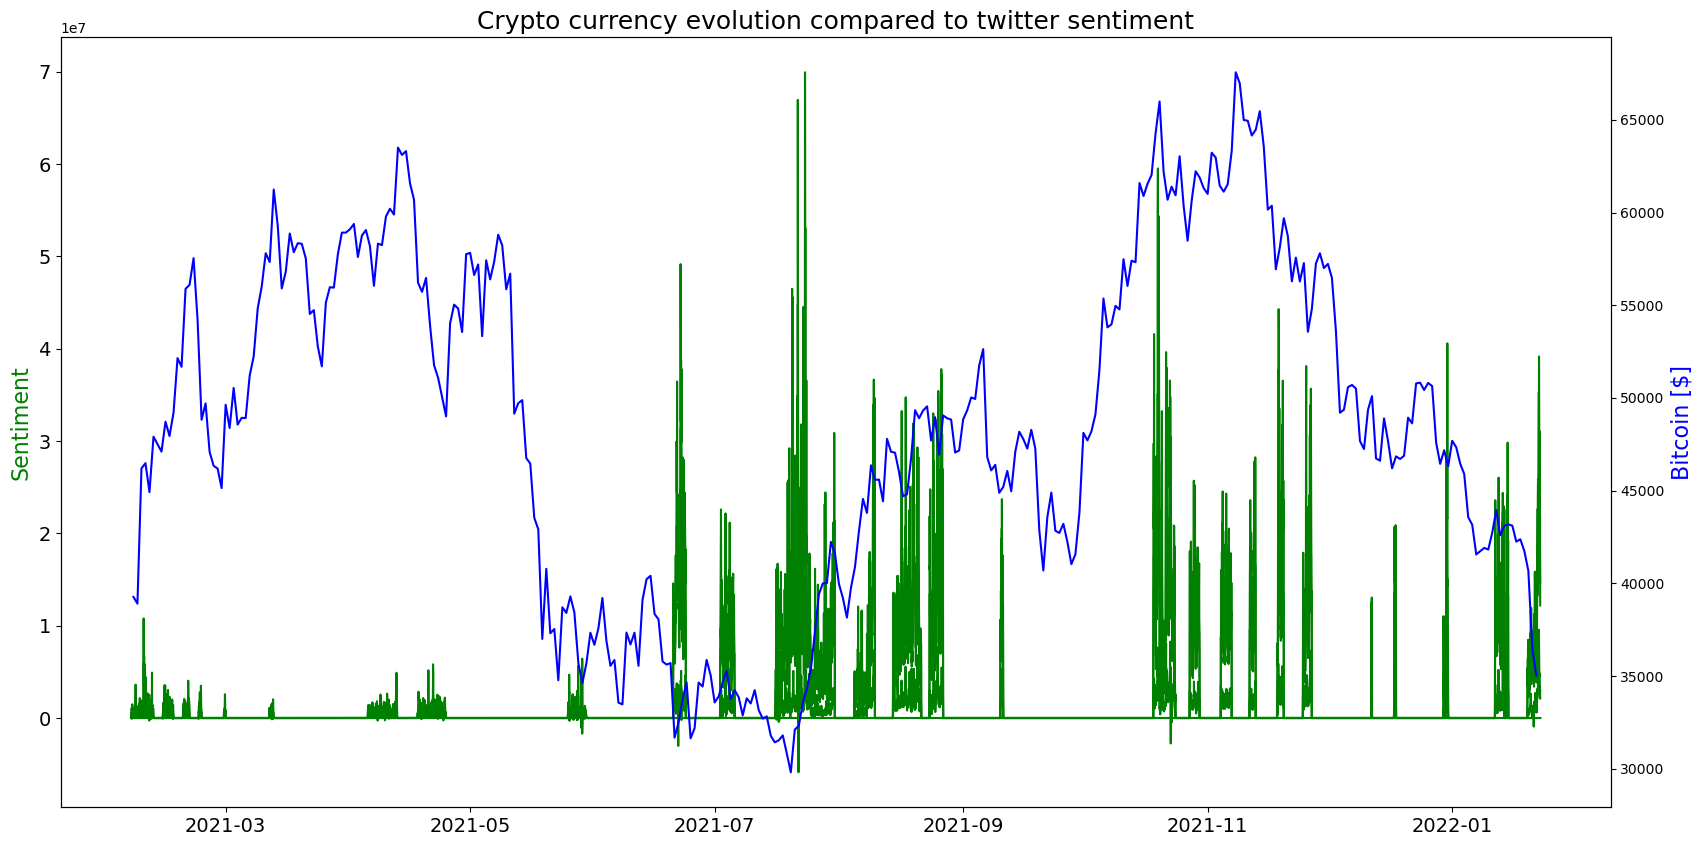

In [15]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()


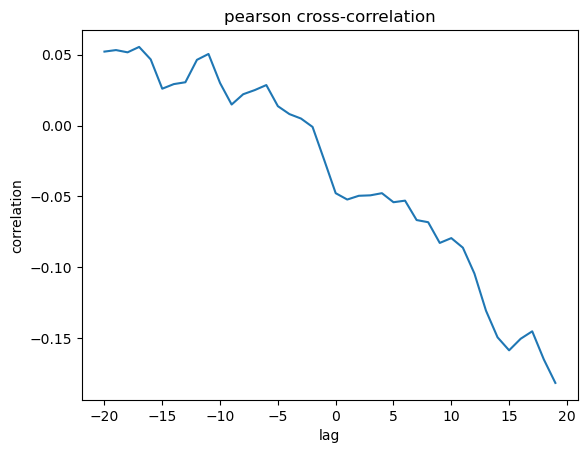

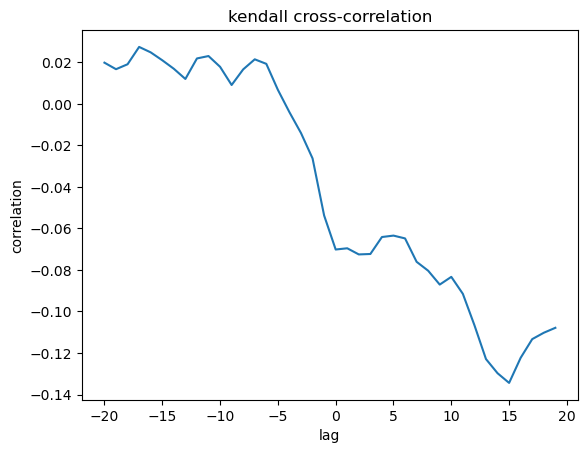

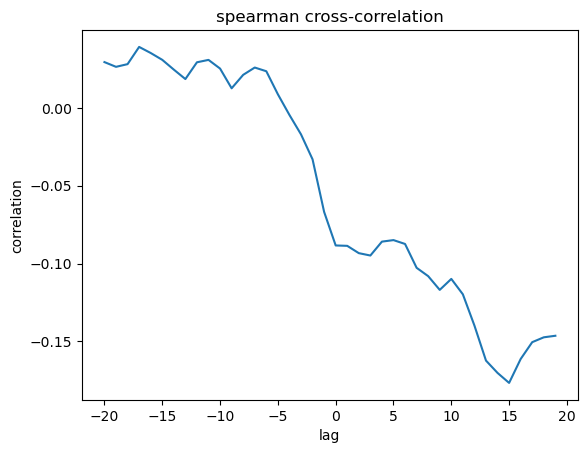

In [16]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()


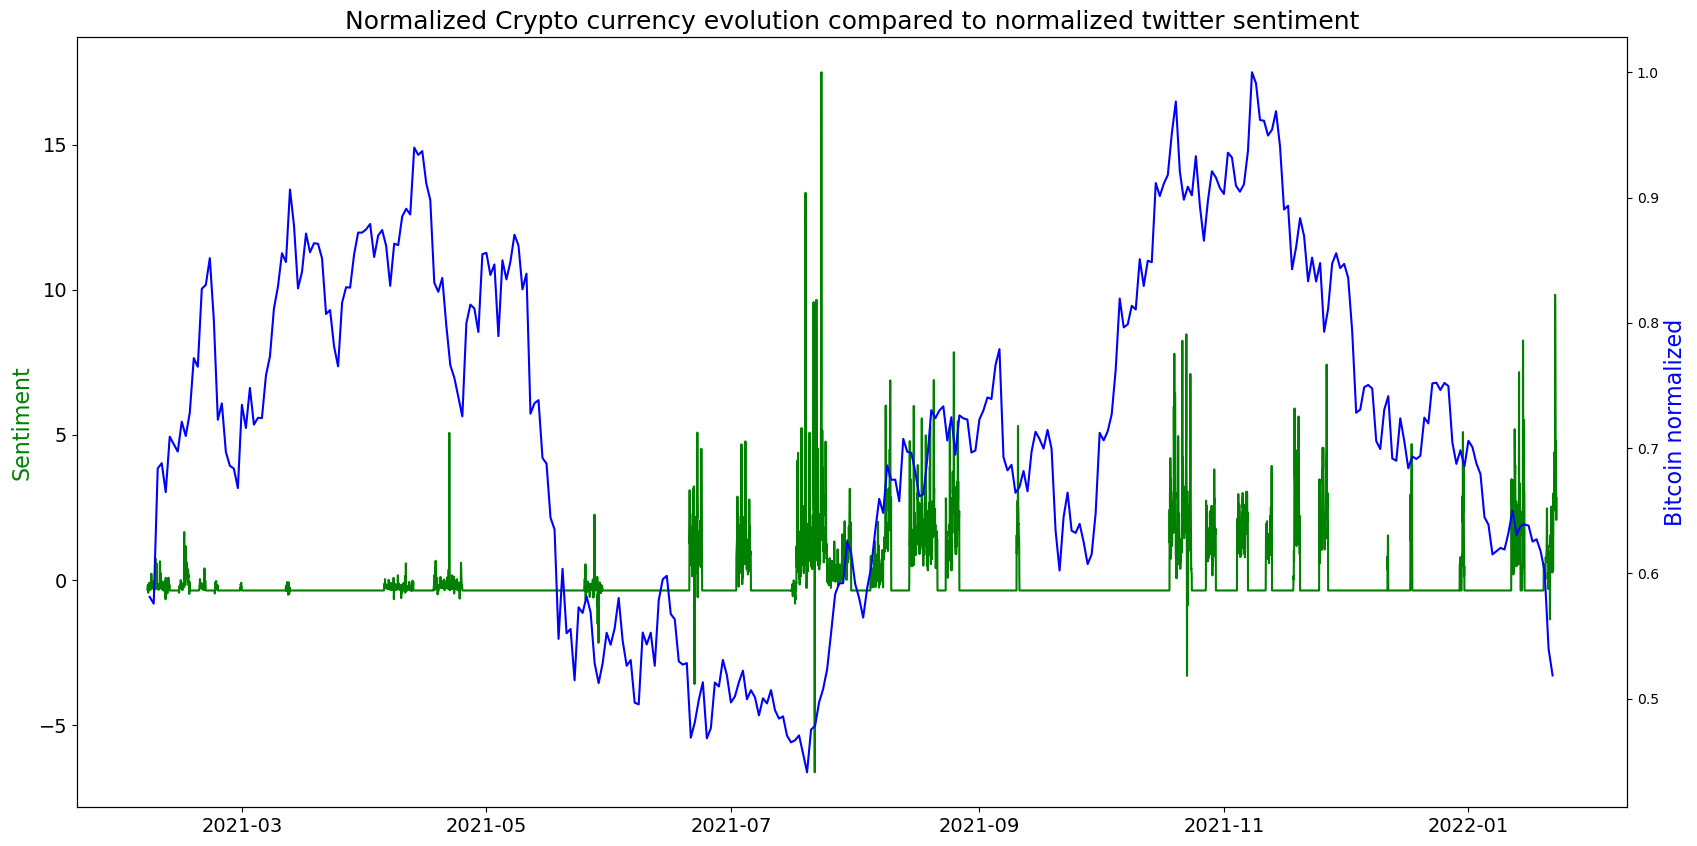

In [17]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

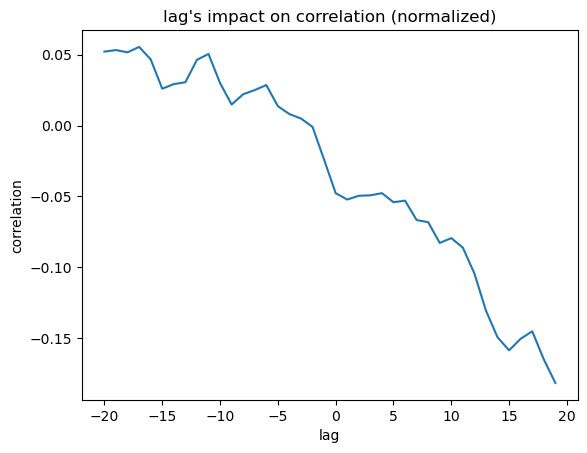

In [18]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [19]:
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

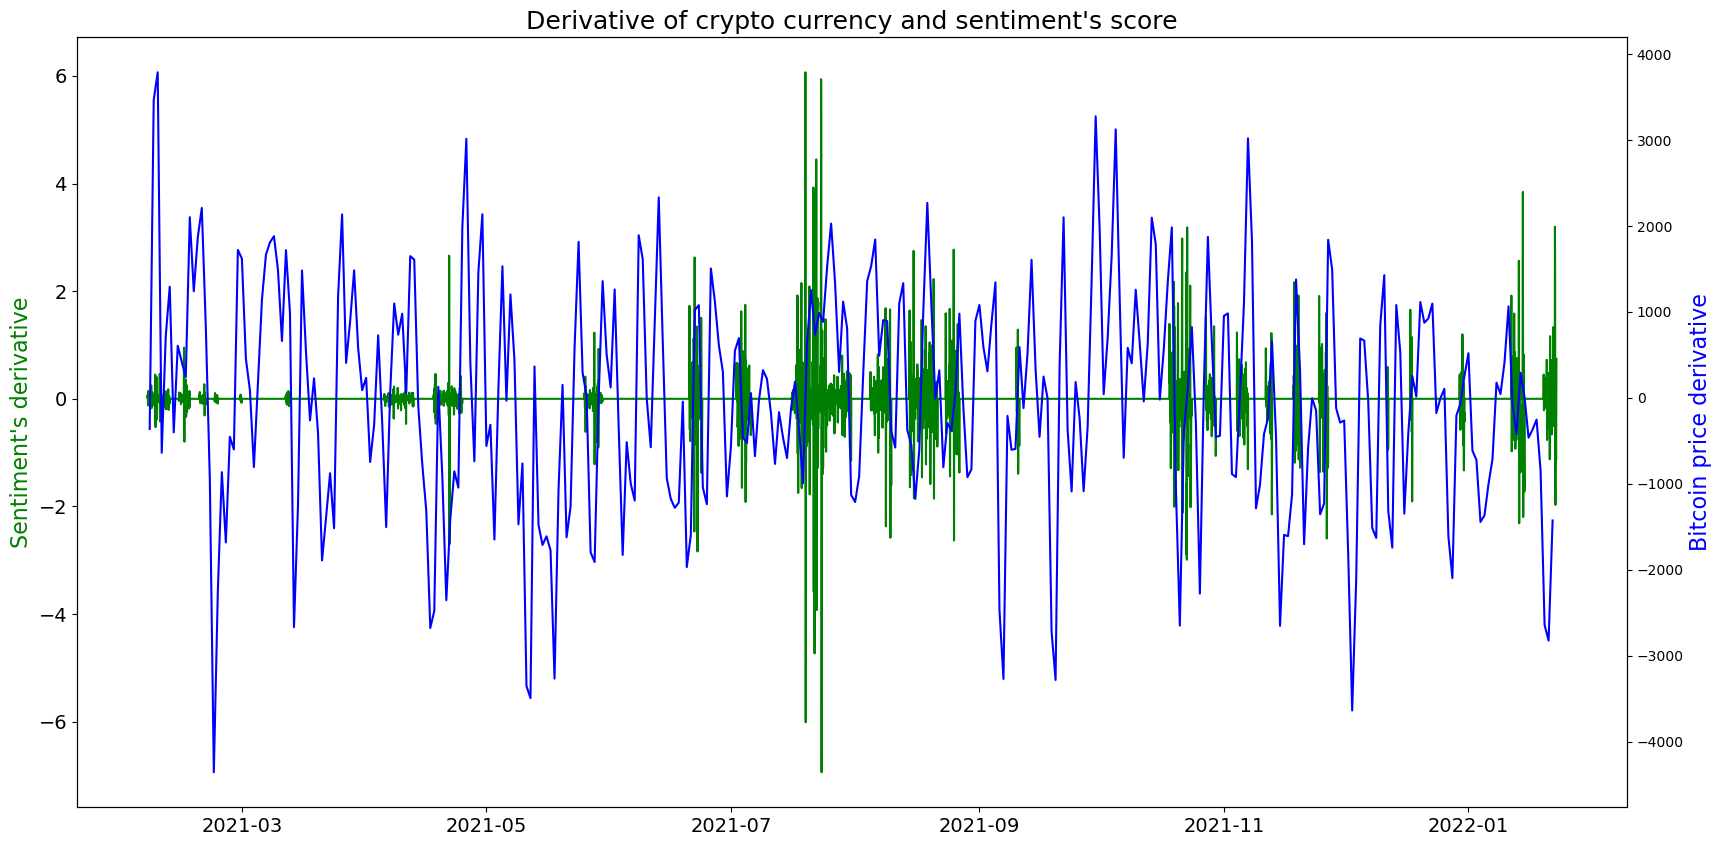

In [20]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()

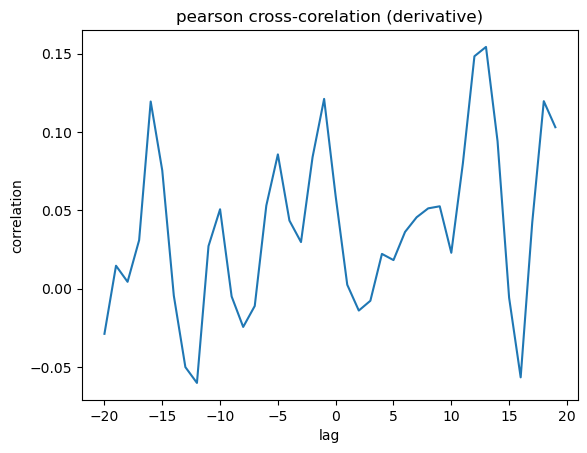

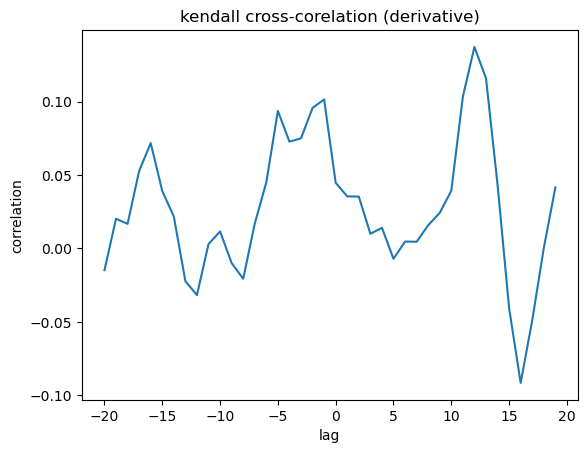

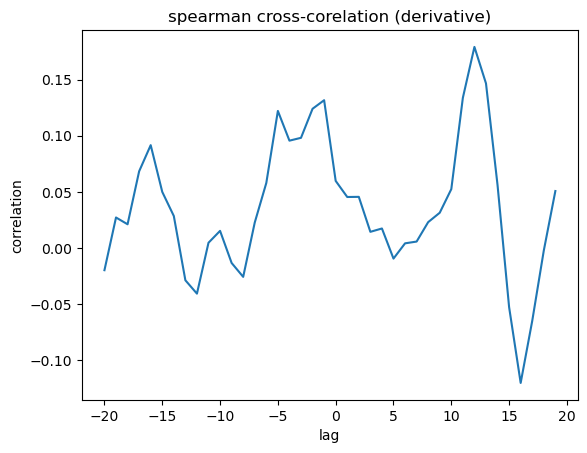

In [21]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()


In [22]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
text_arr = []
text_vals

split_words = texts.split()
print(split_words)
text_without_sw = [t for t in split_words if t not in stop_words]
text_vals = ' '.join(text_without_sw)
print(text_vals)
#text_arr += text_vals

['ElSalvador', 'the', 'first', 'country', 'to', 'make', 'Bitcoin', 'BTC', 'a', 'legal', 'tender', 'has', 'onboarded', '4', 'million', 'users', 'for', 'its', 'government', 'backed', 'BTCwallet', 'Chivo', 'in', 'partnership', 'with', 'digital', 'identity', 'provider', 'Netki', 'according', 'to', 'an', 'announcement']
ElSalvador first country make Bitcoin BTC legal tender onboarded 4 million users government backed BTCwallet Chivo partnership digital identity provider Netki according announcement


In [45]:
texts_cleaned = []
for i in range(len(df['text'])):
    split_text = df['text'][i].lower().split()
    txt_without_sw = [t for t in split_text if t not in stop_words]
    text_vals = ' '.join(txt_without_sw)
    texts_cleaned.append(text_vals)

In [48]:

df_new = pd.DataFrame()
df_new['tweets'] = df['text'].copy()
df_new['cleaned_tweets'] = texts_cleaned
df_new['date'] = df['date']
df_new['date_clean'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df_new.drop(columns='date',inplace=True)
df_new.head()

,tweets,cleaned_tweets,date_clean
0,Blue Ridge Bank shares halted by NYSE after b...,blue ridge bank shares halted nyse bitcoin atm...,2021-02-10
1,Today that s this Thursday we will do a ...,today thursday take 2 friend leowandersleb btc...,2021-02-10
2,Guys evening I have read this article about B...,guys evening read article btc would like share,2021-02-10
3,BTC A big chance in a billion Price 487264...,btc big chance billion price 4872644 0 2021 02...,2021-02-10
4,This network is secured by 9 508 nodes as of t...,network secured 9 508 nodes today soon biggest...,2021-02-10


In [54]:
# compare price ratio in 7 days. price_7_days_later/ price_now 
tmp = crypto_usd_grouped.shift(7)/crypto_usd_grouped
def get_val(x):
    if x < 1:
        return 'negative'
    elif x == 1:
        return 'neutral'
    else:
        return 'positive'

val = tmp.apply(get_val)
time_sentiment = val 


In [69]:
df_new

,tweets,cleaned_tweets,date_clean,crypto_sentiment
0,Blue Ridge Bank shares halted by NYSE after b...,blue ridge bank shares halted nyse bitcoin atm...,2021-02-10,positive
1,Today that s this Thursday we will do a ...,today thursday take 2 friend leowandersleb btc...,2021-02-10,positive
2,Guys evening I have read this article about B...,guys evening read article btc would like share,2021-02-10,positive
3,BTC A big chance in a billion Price 487264...,btc big chance billion price 4872644 0 2021 02...,2021-02-10,positive
4,This network is secured by 9 508 nodes as of t...,network secured 9 508 nodes today soon biggest...,2021-02-10,positive
...,...,...,...,...
2259633,BTC even broke the 42 000 support A clear b...,btc even broke 42 000 support clear break 41 5...,2022-01-19,positive
2259634,ETHFanToken we eating dips like no other ever...,ethfantoken eating dips like ever come join us...,2022-01-19,positive
2259635,The agitation at these price levels is unwarra...,agitation price levels unwarranted market bear...,2022-01-19,positive
2259636,Wake me when it s over Crypto btc Ethereum,wake crypto btc ethereum,2022-01-19,positive


In [64]:
#df_new['crypto_sentiment'] = [time_sentiment[x] if x in time_sentiment.index else np.nan for x in df_new['date_clean']]
df_new['crypto_sentiment'] = df_new['date_clean'].apply(lambda x: time_sentiment.get(x, np.nan))
   

In [74]:
df_new['subjectivity'] = df_new['cleaned_tweets'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df_new['polarity'] = df_new['cleaned_tweets'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_new.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,Blue Ridge Bank shares halted by NYSE after b...,blue ridge bank shares halted nyse bitcoin atm...,2021-02-10,positive,0.1,0.00
1,Today that s this Thursday we will do a ...,today thursday take 2 friend leowandersleb btc...,2021-02-10,positive,0.0,0.00
2,Guys evening I have read this article about B...,guys evening read article btc would like share,2021-02-10,positive,0.0,0.00
3,BTC A big chance in a billion Price 487264...,btc big chance billion price 4872644 0 2021 02...,2021-02-10,positive,0.1,0.00
4,This network is secured by 9 508 nodes as of t...,network secured 9 508 nodes today soon biggest...,2021-02-10,positive,0.2,-0.25


In [75]:
def getscore(value):
    if value < 0:
        return 'negative'
    elif value == 0:
        return 'neutral'
    else:
        return 'positive'
df_new['sentiment'] = df_new['polarity'].apply(getscore)
df_new['target'] = df_new['sentiment'] == df_new['crypto_sentiment']
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tokenized_tweet,sentiment,score
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605.0,4838.0,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after b...,['bitcoin'],Twitter Web App,False,"['blue', 'ridge', 'bank', 'shares', 'halted', ...",0.2960,1432.176180
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532.0,25483.0,False,2021-02-10 23:58:48,Today that s this Thursday we will do a ...,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,"['today', 'that', 's', 'this', 'thursday', 'we...",0.6808,17346.944496
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332.0,924.0,False,2021-02-10 23:54:48,Guys evening I have read this article about B...,NaN,Twitter Web App,False,"['guys', 'evening', 'i', 'have', 'read', 'this...",0.5719,524.906667
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625,129.0,14.0,False,2021-02-10 23:54:33,BTC A big chance in a billion Price 487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,"['btc', 'a', 'big', 'chance', 'in', 'a', 'bill...",0.2500,3.744010
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249,1472.0,10482.0,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,"['this', 'network', 'is', 'secured', 'by', '9'...",-0.2023,-2119.014331


In [77]:
X = df_new['cleaned_tweets']
y = pd.get_dummies(df_new['sentiment']).values
num_values = df_new['sentiment'].nunique()

In [91]:
df_new.to_csv('new_analysed_data')

In [78]:
seed = 42 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1807710,) (451928,) (1807710, 3) (451928, 3)


In [79]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [81]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(1807710, 30) (451928, 30)


In [85]:
import tensorflow.keras.backend as K
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
#from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
#model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_values, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

In [88]:
estimation = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/10
14123/14123 - 559s - loss: 0.0653 - accuracy: 0.9809 - val_loss: 0.0436 - val_accuracy: 0.9884 - 559s/epoch - 40ms/step
Epoch 2/10
14123/14123 - 583s - loss: 0.0376 - accuracy: 0.9900 - val_loss: 0.0390 - val_accuracy: 0.9896 - 583s/epoch - 41ms/step
Epoch 3/10
14123/14123 - 650s - loss: 0.0309 - accuracy: 0.9918 - val_loss: 0.0393 - val_accuracy: 0.9898 - 650s/epoch - 46ms/step
Epoch 4/10
14123/14123 - 624s - loss: 0.0261 - accuracy: 0.9931 - val_loss: 0.0400 - val_accuracy: 0.9897 - 624s/epoch - 44ms/step
Epoch 5/10
14123/14123 - 640s - loss: 0.0224 - accuracy: 0.9941 - val_loss: 0.0424 - val_accuracy: 0.9894 - 640s/epoch - 45ms/step
Epoch 6/10
14123/14123 - 647s - loss: 0.0193 - accuracy: 0.9948 - val_loss: 0.0435 - val_accuracy: 0.9895 - 647s/epoch - 46ms/step
Epoch 7/10
14123/14123 - 623s - loss: 0.0173 - accuracy: 0.9953 - val_loss: 0.0471 - val_accuracy: 0.9889 - 623s/epoch - 44ms/step
Epoch 8/10
14123/14123 - 617s - loss: 0.0152 - accuracy: 0.9958 - val_loss: 0.0493 

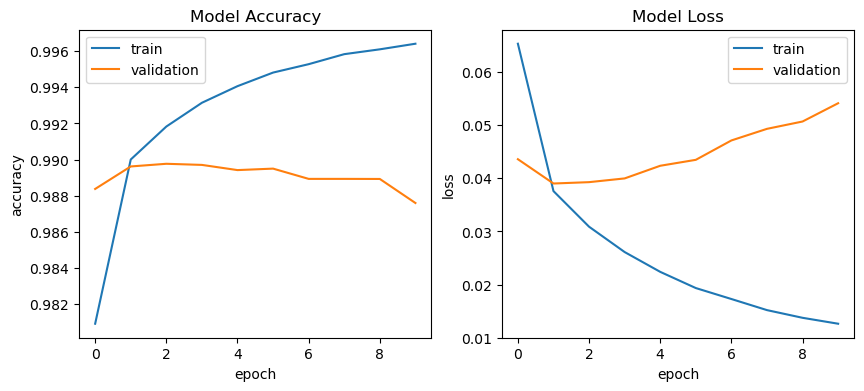

In [89]:
def plot_training_hist(estimation):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(estimation.history['accuracy'])
    ax[0].plot(estimation.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(estimation.history['loss'])
    ax[1].plot(estimation.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(estimation)

In [90]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

14123/14123 [==============================] - 47s 3ms/step


NameError: name 'accuracy_score' is not defined

In [92]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

Accuracy:	98.8%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     48470
           1       0.99      0.99      0.99    181293
           2       0.99      0.99      0.99    222165

    accuracy                           0.99    451928
   macro avg       0.98      0.98      0.98    451928
weighted avg       0.99      0.99      0.99    451928



14123/14123 [==============================] - 47s 3ms/step
2    222165
1    181293
0     48470
dtype: int64
2    221745
1    181911
0     48272
dtype: int64


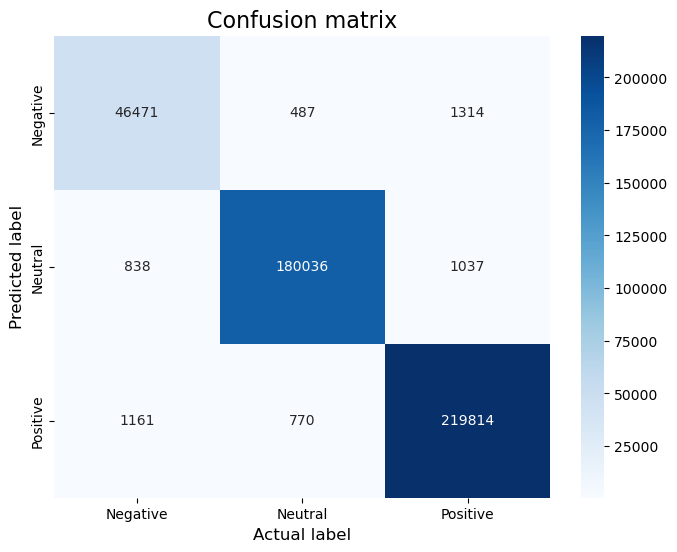

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [110]:
values = df['hashtags'].dropna()
hashtag_list = values.apply(ast.literal_eval)

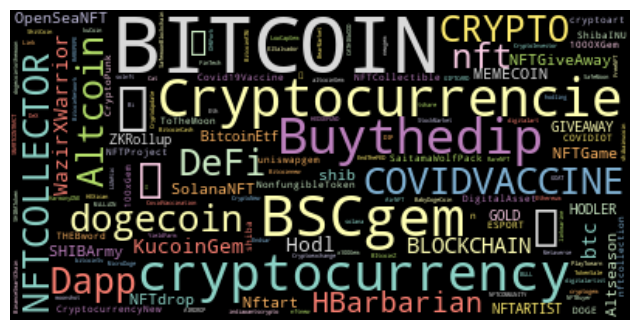

In [121]:

hashtags = list(itertools.chain(*hashtag_list))

# Remove any repeating words using a set
words_eng = list(set(hashtags))
words_list = ' '.join(word for word in words_eng)
c = WordCloud(background_color='black',
                        colormap='Set3',
                          stopwords=set(STOPWORDS),
                          max_words=200,
                          max_font_size=50,
                          random_state=42)
c.generate(words_list)
plt.figure(figsize=(8,6),dpi=100)
plt.imshow(c,interpolation='bilinear')
plt.axis('off')
plt.show()